# 1.  Convolutional Neural Networks applied to classification.

## a) Calculate the dimensionality of the output for the following convolutions sequentially applied to a black and white MNIST input

### (i). Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0  

Input Dimension: 1x32x32
O = (I - K + 2P)/S + 1 = (32 - 2 + 0)/2 + 1 = 16
Output Dimension: 33x16x16 

### (ii). Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1 

Input Dimension: 33x16x16
O = (I - K + 2P)/S + 1 = (16 - 3 + 2)/1 + 1 = 16
Output Dimension: 55x16x16 

### (iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a  Max Pooling with filter size of 2x2 and stride 2. 

Input Dimension: 55x16x16
After Convolution:
O = (16 - 3 + 2)/1 + 1 = 16
Output: 77x16x16
After Max Pooling:
O = (16 - 2)/2 + 1 = 8
Final Output Dimension = 77x8x8  

## (b) (4.5pt) The MNIST data set was, in fact, in color (RGB). This means the depth of the input image would be 3. Calculate the dimensionality of the output for the following convolutions sequentially applied to a RGB MNIST input:

### (i). Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0  

Input Dimension: 3x32x32
O = (I - K + 2P)/S + 1 = (32 - 2 + 0)/2 + 1 = 16
Output Dimension: 3x33x16x16 

### (ii).  Convolution  Filter  size  of  3x3,  number  of  filters  55,  stride  of  1,  padding  of  1.  Followed  by  a  max pooling layer of kernel size 3x3, stride of 1, padding of 0 

Input Dimension: 3x33x16x16
O = (I - K + 2P)/S + 1 = (16 - 3 + 2)/1 + 1 = 16
Output Dimension: 3x55x16x16
After Max Pooling:
O = (16 - 3 + 0)/1 + 1 = 14
Final Output Dimension: 3x55x14x14

### (iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max Pooling with filter size of 2x2 and stride 2.

Input Dimension: 3x55x14x14
After Convolution:
O = (14 - 3 + 2)/1 + 1 = 14
Output: 3x77x14x14
After Max Pooling:
O = (14 - 2)/2 + 1 = 7
Final Output Dimension = 3x77x7x7  

#### (c) (5pt) Next, implement a CNN to see if we can extract additional features from the MNIST data. For this start with one convolutional layer with a 5x5 kernel, with stride of 1, zero-padding of size 2, and 3 output channels. Flatten the resulting feature maps and add a second layer of fully connected (FC) layer to the 10-neuron output layer. Use ReLU as your activation function. Use the ADAM optimizer with learning rate of 1e-3, batchsize of 128, and 30 epochs (you can also train for longer if time permits). Use mini-batches of data  and  converge  your  training  to  where  the  loss  function  is  minimal,  and  choose  some  regularization techniques. Using 3-fold cross-validation and report your average test accuracy. 

In [1]:
import numpy as np
import pickle
import pandas as pd
from torch import nn
import torch
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0')
torch.cuda.empty_cache()
print(torch.cuda.get_device_name(0))

Tesla K80


In [3]:
import os
print(os.getcwd())

/content


In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


X_train: (60000, 32, 32)
Y_train: (60000,)
X_test:  (10000, 32, 32)
Y_test:  (10000,)


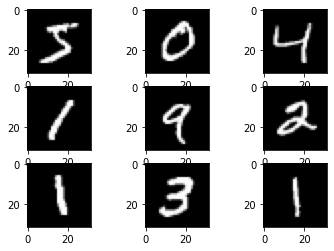

In [5]:
import pickle
(train_X, train_y), (test_X, test_y) = pickle.load(open("drive/MyDrive/mnist.pkl", "rb"))
 
#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
 
#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
for i in range(9):  
    plt.subplot(3,3,i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

In [6]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [7]:
for i in range(60000):
    if np.amax(train_X[i]) != 0:
        train_X[i] = train_X[i]/np.amax(train_X[i])

for i in range(10000):
    if np.amax(test_X[i]) != 0:
        test_X[i] = test_X[i]/np.amax(test_X[i])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26666668,
       0.8745098 , 0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 ,
       0.9882353 , 0.15294118, 0.07450981, 0.15294118, 0.25490198,
       0.8784314 , 0.9882353 , 0.9882353 , 0.7176471 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

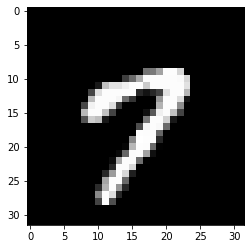

In [8]:
plt.imshow(train_X[15], cmap=plt.get_cmap('gray'))
train_X[15][12]

In [9]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [10]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop,l2,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        """
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float).to(device))
        outputs = torch.tensor(outputs, dtype=torch.int64).to(device)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float).to(device))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64).to(device)

        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    lambda_val = 0.00001
                    change = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss += lambda_val*change
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().cpu().item() * batch_importance
                acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
                epoch_acc += acc.detach().cpu().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs)
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float).to(device))
            outputs = torch.tensor(outputs, dtype=torch.int64).to(device)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            # compute accuracy of classification 
            batch_acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
            losses += loss.detach().cpu().item() * batch_importance
            acc += batch_acc.detach().cpu().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [11]:
from sklearn.model_selection import train_test_split,KFold
def Kfold(model_func,k,Xs,ys,test_Xs,test_ys,epochs=50,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=2e-3,l2=False,
          input_shape=(-1,1024)):
    """ Do Kfold cross validation with the specified arguments
    model_func: function. 
        Constructor of the model.
    k: int. The number of fold
    Xs: np.array, The shape of Xs.reshape(input_shape) should be (ndata,nfeatures)
    ys: np.array shape (ndata,)
    test_Xs: np.array, The shape of test_Xs.reshape(input_shape) should be (ndata,nfeatures)
    test_ys: np.array shape (ndata,)
    epoch: int
    batch_size: int
    early_stop: bool
    lr: float. learning_rate
    l2: bool
    optimizer: 'adam' or 'sgd'
    input_shape: tuple
    """
    
    # The total number of examples for training the network
    total_num=len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_acc_all=[]
    test_acc_all=[]
    fold=0
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        # Decide training examples and validation examples for this fold
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        
        model=model_func()
        ### Use the trainer class to train the model ###
        trainer = Trainer(model,optimizer,lr,epochs,batchsize,input_transform=lambda x: x) ###### what I think might be correct
        log=trainer.train(train_Xs,train_ys,val_Xs,val_ys,early_stop,l2) ####
        
        if draw_curve:
            plt.figure()
            plt.plot(log["losses"], label="losses")
            plt.plot(log["val_losses"], label="validation_losses")
            plt.legend()
            plt.title(f'Fold #{fold} loss')

            plt.figure()
            plt.plot(log["accuracies"], label="accuracies")
            plt.plot(log["val_accuracies"], label="validation_accuracies")
            plt.legend()
            plt.title(f'Fold #{fold} accuracy')
        
        # Report result for this fold
        if early_stop:
            report_idx= np.argmin(log["val_losses"])      
        else:
            report_idx=-1
        test_acc=trainer.evaluate(test_Xs,test_ys,print_acc=False)[1]
        train_acc_all.append(log["accuracies"][report_idx])
        test_acc_all.append(test_acc)
        print("Train accuracy:",log["accuracies"][report_idx])
        print("Validation accuracy:",log["val_accuracies"][report_idx])
        print("Test accuracy:",test_acc)
        
    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all),np.std(test_acc_all)))

In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,3,kernel_size=5,stride=1,padding=2)]) 
        self.fc = nn.ModuleList([nn.Linear(3072,50), nn.Linear(50,10)])
        self.activation = nn.ReLU()
        self = self.to(device)
        
    def forward(self, x):
        x = self.activation(self.conv[0](torch.reshape(x, (x.shape[0], 1, *x.shape[1:])).to(device))) #(B,3,32,32)
        x = nn.Dropout(0.2)(x)
        x = nn.Flatten()(x) #3072
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x
    

Fold #1


  3%|▎         | 1/30 [00:02<01:10,  2.42s/it]

Epoch 1/30 - Loss: 1.717 - Acc: 0.771
              Val_loss: 1.628 - Val_acc: 0.838


 37%|███▋      | 11/30 [00:15<00:25,  1.36s/it]

Epoch 11/30 - Loss: 1.502 - Acc: 0.965
              Val_loss: 1.502 - Val_acc: 0.961


 70%|███████   | 21/30 [00:38<00:17,  1.90s/it]

Epoch 21/30 - Loss: 1.490 - Acc: 0.977
              Val_loss: 1.493 - Val_acc: 0.970


func:'train'  took: 51.6809 sec
Train accuracy: 0.982000000000001
Validation accuracy: 0.9721999999999984
Test accuracy: 0.9713000000000009
Fold #2


  3%|▎         | 1/30 [00:01<00:38,  1.32s/it]

Epoch 1/30 - Loss: 1.732 - Acc: 0.754
              Val_loss: 1.574 - Val_acc: 0.900


 37%|███▋      | 11/30 [00:14<00:25,  1.33s/it]

Epoch 11/30 - Loss: 1.504 - Acc: 0.962
              Val_loss: 1.505 - Val_acc: 0.958


 70%|███████   | 21/30 [00:28<00:12,  1.34s/it]

Epoch 21/30 - Loss: 1.491 - Acc: 0.976
              Val_loss: 1.497 - Val_acc: 0.965


func:'train'  took: 40.2149 sec
Train accuracy: 0.9802500000000013
Validation accuracy: 0.9717999999999982
Test accuracy: 0.9733000000000005
Fold #3


  3%|▎         | 1/30 [00:01<00:39,  1.37s/it]

Epoch 1/30 - Loss: 1.658 - Acc: 0.840
              Val_loss: 1.551 - Val_acc: 0.919


 37%|███▋      | 11/30 [00:15<00:26,  1.37s/it]

Epoch 11/30 - Loss: 1.493 - Acc: 0.974
              Val_loss: 1.494 - Val_acc: 0.968


 70%|███████   | 21/30 [00:28<00:12,  1.34s/it]

Epoch 21/30 - Loss: 1.486 - Acc: 0.982
              Val_loss: 1.490 - Val_acc: 0.973


func:'train'  took: 42.0603 sec
Train accuracy: 0.9844750000000008
Validation accuracy: 0.975349999999998
Test accuracy: 0.9768000000000009
Final results:
Training accuracy:0.982242+-0.001733
Testing accuracy:0.973800+-0.002273


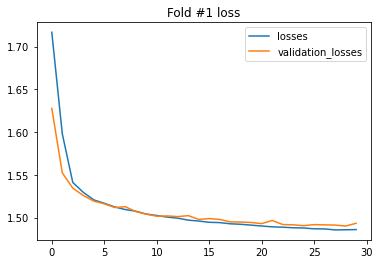

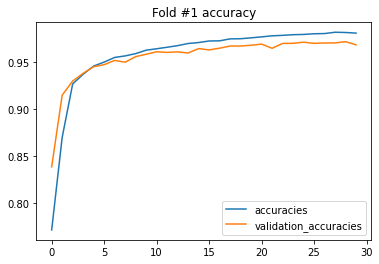

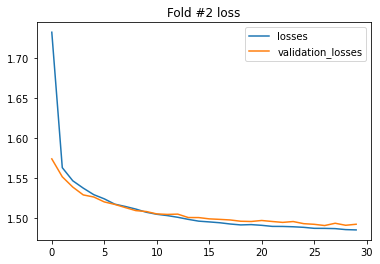

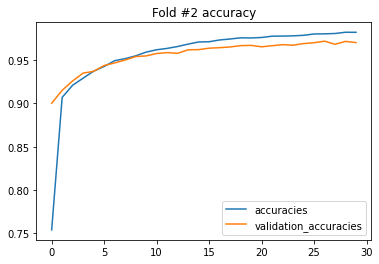

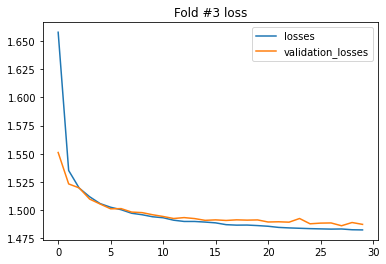

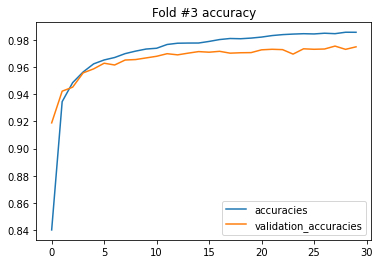

In [16]:
beast = Kfold(LeNet,3,train_X,train_y,test_X,test_y,30,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=1e-3,l2=True,
          input_shape=(-1,1024))

### Average test accuracy was 97.3% with the CNN model, a higher test accuracy compared to models on the last homework.

### (d) (6pt) Now build a deeper (more layers) architecture with two layers each composed of one convolution and  one  pooling  layer.  Flatten  the  resulting  feature  maps  and  use  two  fully  connected  (FC)  layers. 

In [35]:
class DeepLeNet(nn.Module):
    def __init__(self):
        super(DeepLeNet, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,3,kernel_size=5,stride=1,padding=2),nn.Conv2d(3,3,5,1,2)]) 
        self.fc = nn.ModuleList([nn.Linear(2700,200), nn.Linear(200,10)])
        self.activation = nn.ReLU()
        self = self.to(device)
        
    def forward(self, x):
        x = self.activation(self.conv[0](torch.reshape(x, (x.shape[0], 1, *x.shape[1:])).to(device))) #(B,3,32,32)
        x = nn.Dropout(0.2)(x)
        x = nn.MaxPool2d(kernel_size=2,stride=1)(x)
        x = self.activation(self.conv[1](x))
        x = nn.Dropout(0.2)(x)
        x = nn.MaxPool2d(kernel_size=2,stride=1)(x)
        x = nn.Flatten()(x) #3072
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x
    

Fold #1


  3%|▎         | 1/30 [00:02<01:16,  2.65s/it]

Epoch 1/30 - Loss: 1.671 - Acc: 0.802
              Val_loss: 1.609 - Val_acc: 0.853


 37%|███▋      | 11/30 [00:27<00:47,  2.50s/it]

Epoch 11/30 - Loss: 1.483 - Acc: 0.984
              Val_loss: 1.484 - Val_acc: 0.978


 70%|███████   | 21/30 [00:53<00:22,  2.49s/it]

Epoch 21/30 - Loss: 1.480 - Acc: 0.988
              Val_loss: 1.479 - Val_acc: 0.983


func:'train'  took: 75.5300 sec
Train accuracy: 0.9896750000000005
Validation accuracy: 0.983849999999998
Test accuracy: 0.984000000000001
Fold #2


  3%|▎         | 1/30 [00:02<01:12,  2.49s/it]

Epoch 1/30 - Loss: 1.707 - Acc: 0.764
              Val_loss: 1.632 - Val_acc: 0.830


 37%|███▋      | 11/30 [00:27<00:47,  2.48s/it]

Epoch 11/30 - Loss: 1.490 - Acc: 0.977
              Val_loss: 1.486 - Val_acc: 0.976


 70%|███████   | 21/30 [00:52<00:22,  2.49s/it]

Epoch 21/30 - Loss: 1.482 - Acc: 0.987
              Val_loss: 1.481 - Val_acc: 0.981


func:'train'  took: 74.5758 sec
Train accuracy: 0.9889500000000009
Validation accuracy: 0.983399999999998
Test accuracy: 0.9849000000000006
Fold #3


  3%|▎         | 1/30 [00:02<01:11,  2.47s/it]

Epoch 1/30 - Loss: 1.626 - Acc: 0.848
              Val_loss: 1.539 - Val_acc: 0.926


 37%|███▋      | 11/30 [00:27<00:47,  2.50s/it]

Epoch 11/30 - Loss: 1.487 - Acc: 0.980
              Val_loss: 1.484 - Val_acc: 0.977


 70%|███████   | 21/30 [00:52<00:22,  2.51s/it]

Epoch 21/30 - Loss: 1.482 - Acc: 0.986
              Val_loss: 1.479 - Val_acc: 0.982


func:'train'  took: 75.0840 sec
Train accuracy: 0.9875500000000001
Validation accuracy: 0.982449999999998
Test accuracy: 0.9755000000000005
Final results:
Training accuracy:0.988725+-0.000882
Testing accuracy:0.981467+-0.004235


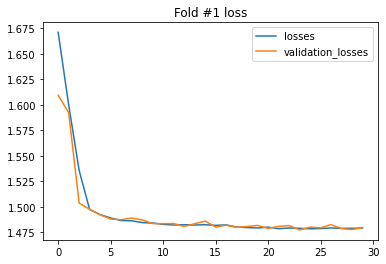

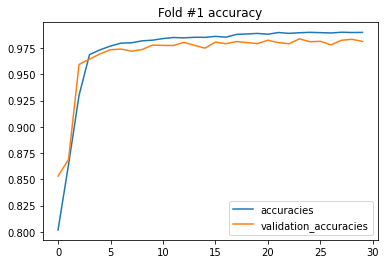

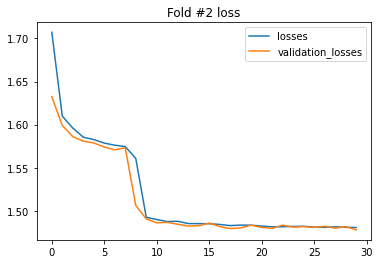

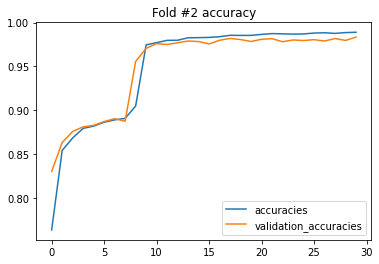

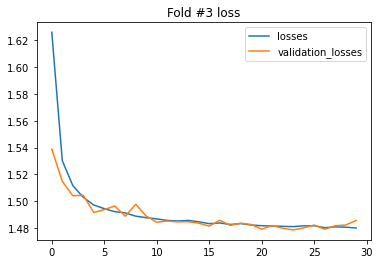

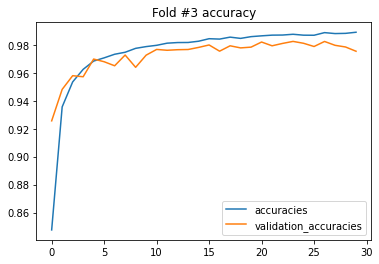

In [36]:
beastx = Kfold(DeepLeNet,3,train_X,train_y,test_X,test_y,30,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=1e-3,l2=True,input_shape=(-1,1024))

### By increasing the depth and changing a few other parameters, we reached a test accuracy of 98%!